In [15]:
from emle.models import EMLE
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import pickle as pkl
import torch
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from math import sqrt

In [16]:
# Load the reference data
with open(
    "/home/joaomorado/mnsol_sampling/run_fixed_test/merged/output_ref_data.pkl",
    "rb",
) as f:
    data = pkl.load(f)


# Load the MBIS data
with open(
    "/home/joaomorado/mnsol_sampling/run_fixed_test/merged/ligand_mbis_plot_data.mat",
    "rb",
) as f:
    mbis_data = scipy.io.loadmat(f)["e_static_mbis"][0]

# Bespoke model
use_bespoke = True
bespoke_model = (
    "/home/joaomorado/mnsol_sampling/run_fixed_test/merged/ligand_bespoke.mat"
    if use_bespoke
    else None
)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
emle_model = EMLE(device=device, dtype=dtype, model=bespoke_model)

In [18]:
# Calculate the predicted static and induction energies
e_static_emle = []
e_ind_emle = []
for i in range(len(data["z"])):
    z = torch.tensor(data["z"][i], device=device, dtype=torch.int64)
    charges_mm = torch.tensor(data["charges_mm"][i], device=device, dtype=dtype)
    xyz_qm = torch.tensor(data["xyz_qm"][i], device=device, dtype=dtype)
    xyz_mm = torch.tensor(data["xyz_mm"][i], device=device, dtype=dtype)
    e_static, e_ind = emle_model.forward(z, charges_mm, xyz_qm, xyz_mm)
    e_static_emle.append(e_static * HARTREE_TO_KJ_MOL)
    e_ind_emle.append(e_ind * HARTREE_TO_KJ_MOL)

<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1946535/1033987153.py:37: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1946535/1033987153.py:38: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1946535/1033987153.py:57: SyntaxWarning: invalid escape sequence '\m'
  axes[1].se

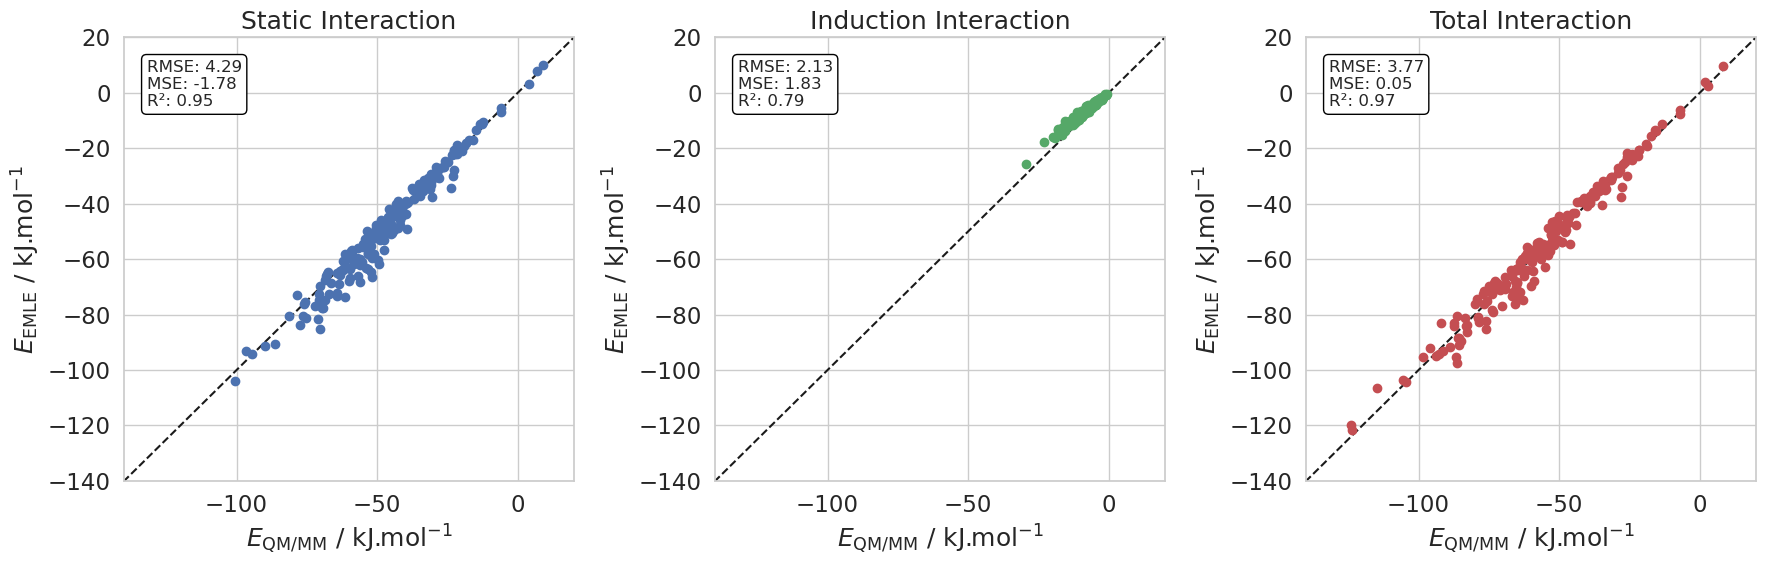

In [19]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", font_scale=1.5)

# Example data (replace with your actual data)
e_static = np.array([x.item() for x in data["e_static"]])
e_ind = np.array([x.item() for x in data["e_ind"]])
e_static_emle = np.array([x.item() for x in e_static_emle])
e_ind_emle = np.array([x.item() for x in e_ind_emle])

# Create the figure and axes for 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the x values for the plot (reference line)
x = np.linspace(-1000, 1000, 100)
y = x


# Function to compute RMSE, MSE, and R^2
def compute_metrics(true_values, predicted_values):
    mse = np.mean(predicted_values - true_values)
    rmse = sqrt(np.mean((predicted_values - true_values) ** 2))
    r2 = r2_score(true_values, predicted_values)
    return rmse, mse, r2


# Set limits for all subplots and plot reference line
xmin, xmax = -140, 20
ymin, ymax = -140, 20
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot(x, y, "k--", label="Reference Line")

# Static subplot
rmse_static, mse_static, r2_static = compute_metrics(e_static, e_static_emle)
axes[0].plot(e_static, e_static_emle, "bo", label="Static")
axes[0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[0].set_title("Static Interaction")
# axes[0].legend()

# Display RMSE, MSE, R^2 on the Static plot
axes[0].text(
    0.05,
    0.95,
    f"RMSE: {rmse_static:.2f}\nMSE: {mse_static:.2f}\nR²: {r2_static:.2f}",
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Induction subplot
rmse_ind, mse_ind, r2_ind = compute_metrics(e_ind, e_ind_emle)
axes[1].plot(e_ind, e_ind_emle, "go", label="Induction")
axes[1].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[1].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[1].set_title("Induction Interaction")
# axes[1].legend()

# Display RMSE, MSE, R^2 on the Induction plot
axes[1].text(
    0.05,
    0.95,
    f"RMSE: {rmse_ind:.2f}\nMSE: {mse_ind:.2f}\nR²: {r2_ind:.2f}",
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Total subplot
rmse_total, mse_total, r2_total = compute_metrics(
    e_static + e_ind, e_static_emle + e_ind_emle
)
axes[2].plot(e_static + e_ind, e_static_emle + e_ind_emle, "ro", label="Total")
axes[2].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[2].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[2].set_title("Total Interaction")
# axes[2].legend()

# Display RMSE, MSE, R^2 on the Total plot
axes[2].text(
    0.05,
    0.95,
    f"RMSE: {rmse_total:.2f}\nMSE: {mse_total:.2f}\nR²: {r2_total:.2f}",
    transform=axes[2].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

# Adjust the layout for better spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1946535/355127821.py:36: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
/tmp/ipykernel_1946535/355127821.py:37: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")


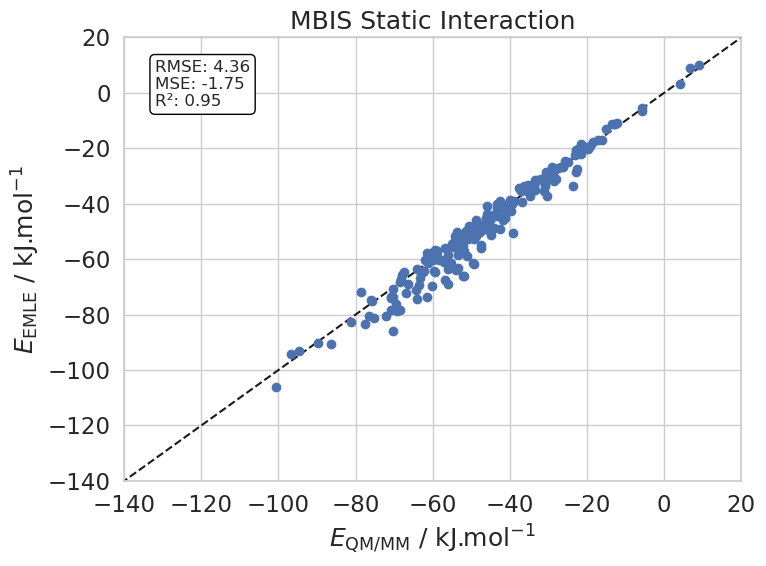

In [20]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", font_scale=1.5)

# Example data (replace with your actual data)
e_static = np.array([x.item() for x in data["e_static"]])
e_static_emle = mbis_data

# Create the figure and axes for 3 subplots
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
axes = [axes]

# Define the x values for the plot (reference line)
x = np.linspace(-1000, 1000, 100)
y = x


# Function to compute RMSE, MSE, and R^2
def compute_metrics(true_values, predicted_values):
    mse = np.mean(predicted_values - true_values)
    rmse = sqrt(np.mean((predicted_values - true_values) ** 2))
    r2 = r2_score(true_values, predicted_values)
    return rmse, mse, r2


# Set limits for all subplots and plot reference line
xmin, xmax = -140, 20
ymin, ymax = -140, 20
for ax in axes:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot(x, y, "k--", label="Reference Line")

# Static subplot
rmse_static, mse_static, r2_static = compute_metrics(e_static, e_static_emle)
axes[0].plot(e_static, e_static_emle, "bo", label="Static")
axes[0].set_xlabel("$E_{\mathrm{QM/MM}}$ / kJ.mol$^{-1}$")
axes[0].set_ylabel("$E_{\mathrm{EMLE}}$ / kJ.mol$^{-1}$")
axes[0].set_title("MBIS Static Interaction")
# axes[0].legend()

# Display RMSE, MSE, R^2 on the Static plot
axes[0].text(
    0.05,
    0.95,
    f"RMSE: {rmse_static:.2f}\nMSE: {mse_static:.2f}\nR²: {r2_static:.2f}",
    transform=axes[0].transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
)

plt.tight_layout()

# Show the plot
plt.show()